# Import statements

In [1]:
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

2.17.0


# Model

First we load MobileNet model

In [61]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[:n]

# See the classes to train on
selected_classes = get_classes(10)

    
# Print the number of elements (images) in each class
dog_class_directory = os.getcwd() + '/dog_classes'  # Define the directory path again

for c in selected_classes:
    class_directory = os.path.join(dog_class_directory, c)  # Full path to the class folder
    # List files in the class folder and count them
    num_images = len([f for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))])
    print(f"Class '{c}' has {num_images} images.")

Class '201-n000024-schipperke' has 201 images.
Class '245-n000098-Australian_Shepherd' has 245 images.
Class '274-n000110-Shetland_sheepdog' has 274 images.
Class '225-n000062-black_and_tan_coonhound' has 225 images.
Class '228-n000085-Gordon_setter' has 228 images.
Class '361-n000123-Shih_Tzu' has 361 images.
Class '224-n000056-Scottish_deerhound' has 224 images.
Class '205-n000029-Pembroke' has 205 images.
Class '217-n000050-bluetick' has 217 images.
Class '205-n000030-Tibetan_mastiff' has 205 images.


In [62]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

Add new top layers (decoder)

In [63]:
# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
preds = Dense(len(selected_classes),activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

In [64]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


Define the training set and dataset. Both are of type `Dataloader`

In [65]:
dog_class_directory = os.getcwd()+'/dog_classes'

selected_classes = get_classes(10)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)


Found 2385 files belonging to 10 classes.
Using 1908 files for training.
Found 2385 files belonging to 10 classes.
Using 477 files for validation.


Define the optimizer and train the model

In [66]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=30)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.1494 - loss: 2.3467 - val_accuracy: 0.2642 - val_loss: 2.0968
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.2885 - loss: 1.9942 - val_accuracy: 0.3187 - val_loss: 2.0120
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.3411 - loss: 1.8646 - val_accuracy: 0.3333 - val_loss: 1.9422
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.3967 - loss: 1.7663 - val_accuracy: 0.3312 - val_loss: 1.9089
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - accuracy: 0.4319 - loss: 1.6680 - val_accuracy: 0.3732 - val_loss: 1.8730
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - accuracy: 0.4521 - loss: 1.6212 - val_accuracy: 0.3585 - val_loss: 1.8442
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - accuracy: 0.4837 - loss: 1.5362 - val_accuracy: 0.3354 - val_loss: 1.8519
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.4910 - loss: 1.5140 - val_accuracy: 0.385

Plot `accuracy` against `epochs`.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


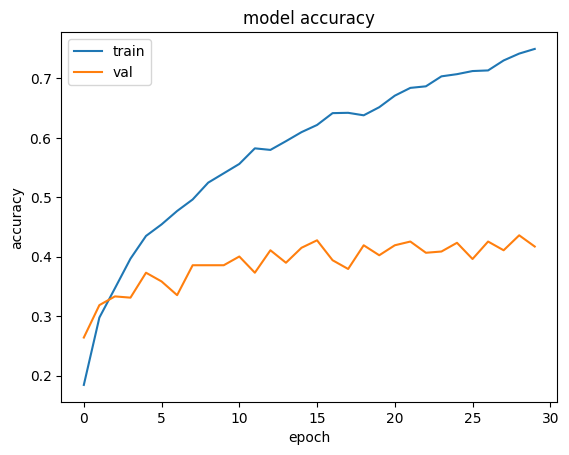

In [71]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Plot `loss` against `epochs`

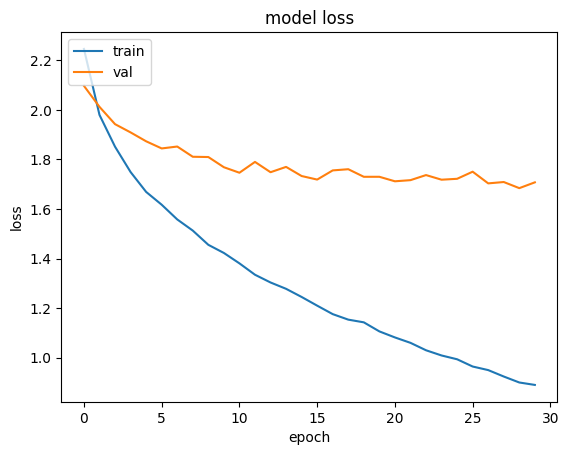

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()